In [1]:
import pandas as pd 
import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

#relax the display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')

gasConsumption.tail(5)

,Date,Corrib production,Moffat,ROI imports via interconnector,Total
2094,26/09/2023,33.912350,101.000000,71.279813,206.192163
2095,27/09/2023,33.630297,105.766667,66.536949,205.933913
2096,28/09/2023,33.749208,98.122222,62.506009,194.377439
2097,29/09/2023,33.814360,129.988889,91.462766,255.266015
2098,30/09/2023,33.599192,98.900000,60.503819,193.003011


In [3]:
gasConsumption = gasConsumption.drop(columns = ['Corrib production', 'Moffat', 'ROI imports via interconnector'])

In [4]:
gasConsumption.index = pd.to_datetime(gasConsumption['Date'], format='%d/%m/%Y')
del gasConsumption['Date']

In [5]:
gasConsumption

,Total
Date,
2018-01-01,200.528802
2018-01-02,204.880714
2018-01-03,246.535364
2018-01-04,307.661627
2018-01-05,314.391491
2018-01-06,286.632677
2018-01-07,342.368707
2018-01-08,314.175790
2018-01-09,296.656576


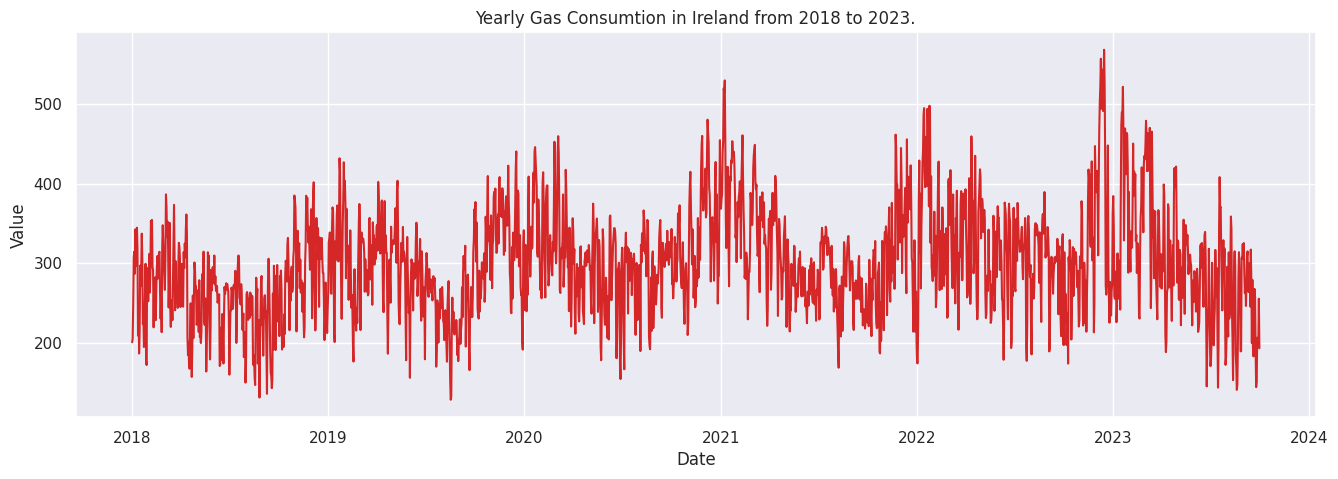

In [16]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(gasConsumption, x=gasConsumption.index, y=gasConsumption.Total, title='Yearly Gas Consumtion in Ireland from 2018 to 2023.') 

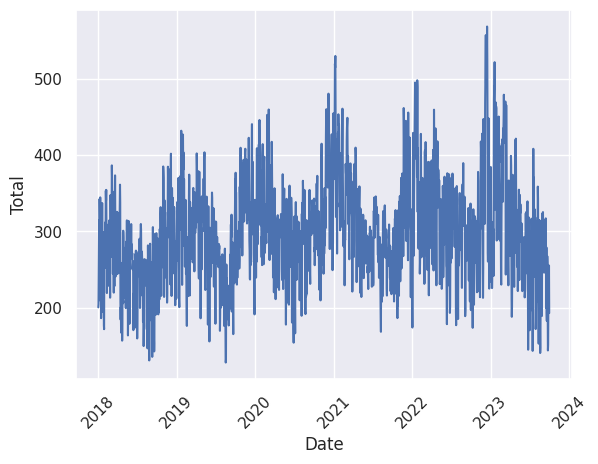

In [6]:
sns.set()
plt.ylabel('Total')
plt.xlabel ('Date')
plt.xticks(rotation =45)
plt.plot(gasConsumption.index, gasConsumption [ 'Total'],)
plt.show()

In [7]:
train =gasConsumption[gasConsumption.index < pd.to_datetime('29-09-2022',format = '%d-%m-%Y')]
test =gasConsumption[gasConsumption.index >= pd.to_datetime('29-09-2022',format = '%d-%m-%Y')]

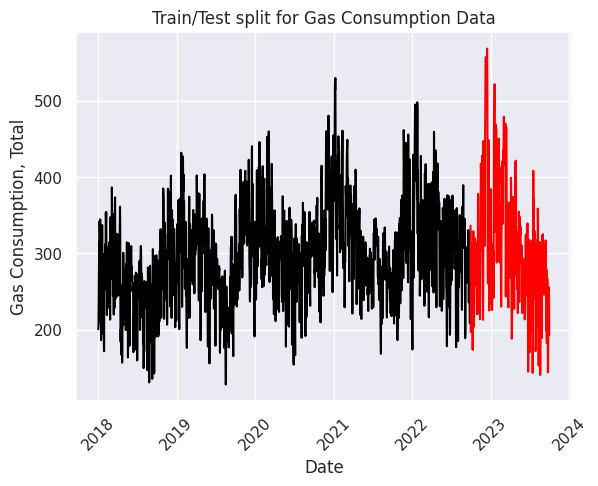

In [8]:
plt.plot(train,color ='black')
plt.plot(test,color = 'red')
plt.ylabel('Gas Consumption, Total')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title ('Train/Test split for Gas Consumption Data')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24022D+00    |proj g|=  3.57837D-02

At iterate    5    f=  5.23870D+00    |proj g|=  7.90533D-04

At iterate   10    f=  5.23862D+00    |proj g|=  1.45574D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   2.847D-05   5.239D+00
  F =   5.2386188993348259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


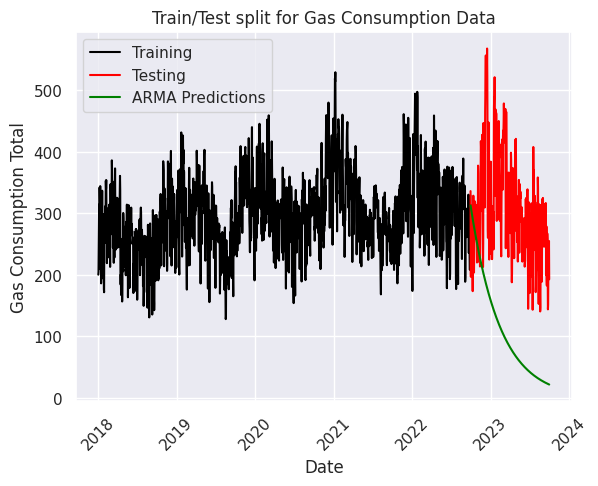

In [9]:
from statsmodels.tsa.arima.model import ARIMA


y = train['Total']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARMA = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Gas Consumption Total')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gas Consumption Data")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.legend()
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Total"].values, y_pred_df["Predictions"]))
print("ARMA RMSE: ",arma_rmse)

ARMA RMSE:  221.63967794599256


In [11]:
from statsmodels.tsa.arima.model import ARIMA

ARIMAmodel = SARIMAX(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36221D+00    |proj g|=  8.86860D-01


 This problem is unconstrained.



At iterate    5    f=  5.69052D+00    |proj g|=  7.87981D-02

At iterate   10    f=  5.66625D+00    |proj g|=  3.11437D-02

At iterate   15    f=  5.65728D+00    |proj g|=  1.14116D-02

At iterate   20    f=  5.62889D+00    |proj g|=  3.17451D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     29      1     0     0   1.020D-05   5.628D+00
  F =   5.6279096333262393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


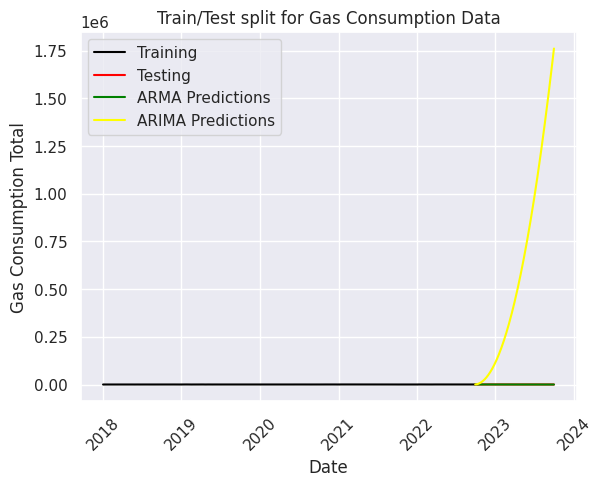

In [12]:

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Gas Consumption Total')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gas Consumption Data")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()